In [19]:
if False:
    import zipfile
    def extract_zip(filename):
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall('./data/')

    extract_zip('val.zip')

In [248]:
%%time
import numpy as np
import pandas as pd
from tqdm import tqdm
import wandb
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

Wall time: 0 ns


In [249]:
%%time
from models import DecoderRNN, EncoderCNN
from dataloader import VizWizImageCaptioning
from image_loader import df_from_vizwiz, df_from_val_json
from vizwiz_api.vizwiz import VizWiz

Wall time: 0 ns


In [250]:
%%time
from models import DecoderRNN, EncoderCNN
from dataloader import VizWizImageCaptioning
from image_loader import df_from_vizwiz, df_from_val_json
from vizwiz_api.vizwiz import VizWiz

Wall time: 0 ns


In [251]:
%%time
import torch
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchtext import vocab
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

Wall time: 0 ns


# DEL Mini Challenge 2
## Overview
### [Describe Images Taken by People Who Are Blind](https://vizwiz.org/tasks-and-datasets/image-captioning/)
Observing that people who are blind have relied on (human-based) image captioning services to learn about images they take for nearly a decade, we introduce the first image captioning dataset to represent this real use case. This new dataset, which we call VizWiz-Captions, consists of 39,181 images originating from people who are blind that are each paired with 5 captions. Our proposed challenge addresses the task of predicting a suitable caption given an image. Ultimately, we hope this work will educate more people about the technological needs of blind people while providing an exciting new opportunity for researchers to develop assistive technologies that eliminate accessibility barriers for blind people.

### Dataset

The VizWiz-Captions dataset includes:

    23,431 training images
    117,155 training captions
    7,750 validation images
    38,750 validation captions
    8,000 test images
    40,000 test captions

The download files is organized as follows:

    Images: training, validation, and test sets
    Annotations and APIs:
        Images are split into two JSON files: train and validation. Captions are publicly shared for the train and validation splits and hidden for the test split. There also is a “text_detected” flag which is set to true for the image if it is set to true for at least three of the five crowdsourced results and false otherwise.
        APIs are provided to demonstrate how to parse the JSON files and evaluate methods against the ground truth.

### Details about each image are in the following format:

    images = [image]

    image = {
        "file_name": "VizWiz_train_00023410.jpg",
        "id": 23410
        "text_detected": true
    }

    annotations = [annotation]

    annotation = {
        "image_id": 23410,
        "id": 117050,
        "caption": "A plastic rewards card lying face down on the floor."
        "is_rejected": false,
        "is_precanned": false,
        "text_detected": true
    }

## General Model Structure
In this Mini-Challenge we had to create Captions for Images. For this, we used a CNN -> LSTM - Architecture. For the CNN-Part, we used a pretrained Model [ResNet101](https://pytorch.org/hub/pytorch_vision_resnet/) without the last layer. 

## Parameter
Most parameter are saved in two dictionaries: `model_params` and `training_params`. `model_params` gets passed to both models; `encoder` (CNN) and `decoder` (LSTM). Both can be found in `models.py`.

## Preprocessing
To make words available to math, we need to translate them into numbers (label-encoding). Basically, each word gets assigned an integer. Pytorch offers great help for this with [torchtext.vocab](https://pytorch.org/text/stable/vocab.html); We can pass our words to the class and the `vocab` will take over the label-encoding. Also, it offers a function `itos`, which translates back numbers to their corresponding words.

### Word Embeddings
To avoid dealing with the high-dimensionality of Onehot-Encoding, we use Embedding: Basically, we train a Layer to display labeled-encoded words in a higher dimension. There are also pretrained models of this, like [Word2Vec](https://en.wikipedia.org/wiki/Word2vec). However, for this challenge we trained our own embedding.

Also, a LSTM-Cell does only handle one word at a time, so we need to split them and feed the sentence 1-by-1. This is done with a `Tokenizer`, which splits a string by a predefined delimiter. Pytorch also offers a premade solution for this: [get_tokenizer](https://pytorch.org/text/stable/data_utils.html).

## CNN
As mentioned before, we used a Pretrained Model ([ResNet101](https://pytorch.org/hub/pytorch_vision_resnet/)). However, functions here are written generically, so you can pass anyone of the pretrained CNN-Models of Pytorch. The Class `Encoder` (found in models.py), will automatically remove the last layer and add the correct dimension based on the dictionary `model_params`, which gets passed when initiating the class. More about the dimensions and architecture can be found as comments.

## LSTM
The Output of the CNN (`features`) is fed into the [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) as follows: In first step of the LSTM, we pass the `features` as the `cell state` of the `hidden state` and pass the first token `TOKEN_START` (usually \<BOS\>, meaning 'Beginning Of Sentence') to the LSTM and save the `output` and the new `hidden state`. We could also pass the `features` as input. Now, during training, test or sampling, different things happen;

### Training
During training, we pass the `features` and the true `captions` we train the LSTM on. First, we pass an empty `hidden state` and the `features` to the LSTM. Next, the Output of the LSTM is taken and passed to the `inverse word embedding`; This is appended to a list and corresponds to the first word of the prediction caption in a `softmax-way`. 

Now, the first word of the passed `true captions` is taken and embedded and passed as input, together with the `hidden state` as the new `hidden state` from before, to the LSTM. We keep doing this until we reach the maximum sentence length defined in a parameter. This is then passed to the loss function `CrossEntropyLoss`, which accepts the list with the `outputs` and the true `captions`. From this, the loss is calculated and from the loss, the gradient with backpropagation is calculated.

[Pytorchs' CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) accepts the ground truth `target` (our `captions`) being labeled-encoded, which is used to define which column of the index of the prediction is correct one. So basically, we pass our prediction in the dimension of `<SENTENCE LENGTH>x<VOCAB SIZE>` and the `target` have the dimension `<SENTENCE LENGTH>x1`

### Test
To calculate the test-loss, everything is identical to Training, except that we pass the `prediction` of the LSTM-Cell before instead of the `true caption` to the next step of the LSTM.

### Sample
To calculate the caption of an image, we do everything in the same way as with the Test-Loss calculation, except that instead of saving all of the `outputs` of the LSTM, we only take the max of a specific row. Thus, we get back the labeled-encoded sentence, which we can translate back with the itos-function of `torchtext.vocab`.


## Data Loading
In this section, the data is loaded. 

In [252]:
# Parameters and settings:
PATH_TO_ANN = 'data/annotations/'
PATH_TO_PICTURES = 'data/'

## VizWiz API 
The [VizWiz API](https://github.com/zmcmcc/vizwiz-api) greatly helps us to load images and captions of the VizWiz Image Captioning Project. From the WizWiz-Json (containing all informations), a DataFrame can easily be created as seen in `image_loader.py`. Also, if allows us to evaluate our predictions. In future, we could use it to calculate scores like `bleu` or `rouge`.

In [253]:
### WizWiz command supported by the VizWiz-Class: 
#  VizWiz     - VizWiz api class that loads VizWiz annotation file and prepare data structures.
#  getImgIds  - Get img ids that satisfy given filter conditions.
#  loadImgs   - Load imgs with the specified ids.
#  getAnnIds  - Get ann ids that satisfy given filter conditions.
#  loadAnns   - Load anns with the specified ids.
#  showAnns   - Display the specified annotations.
#  loadRes    - Load algorithm results and create API for accessing them.
#  download   - Download COCO images from mscoco.org server.
VizWiz(PATH_TO_ANN + 'train.json', ignore_rejected=True, ignore_precanned=True)

loading annotations into memory...
Done (t=0.20s)
creating index...
index created! imgs = 23431, anns = 100575


In [254]:
# PARAMS:
MAX_ANNS = 100575 # Checkable in the annotation-json. Corresponds to the total number of annotations existing to tell the image_loader when to stop to look for annotations (see image_loader.py)

In [255]:
# Create DataFrame containing captions and the images corresponding to those captions:
df = df_from_vizwiz(MAX_ANNS, verbose=0)

loading annotations into memory...
Done (t=0.21s)
creating index...
index created! imgs = 23431, anns = 100575


In [256]:
# Sample Data
df.sample(5)

,caption,image_id,is_precanned,is_rejected,id,text_detected,url,split_type
29102,An illustration from Peter Rabbit appears on a...,6758,False,False,33793,True,data/train/VizWiz_train_00006758.jpg,train
5326,Electronic parts cased and uncased placed insi...,1242,False,False,6214,True,data/train/VizWiz_train_00001242.jpg,train
85533,A person has their sneaker right on the ground.,19863,False,False,99316,True,data/train/VizWiz_train_00019863.jpg,train
56489,A can of isotonic nutrition is laying on a cou...,13116,False,False,65580,True,data/train/VizWiz_train_00013116.jpg,train
15617,a couple products of candles and other things,3617,False,False,18087,True,data/train/VizWiz_train_00003617.jpg,train


## Caption Preprocessing
In this part the captions get preprocessed, as outlined at the beginning.
- Captions get tokenized
- Some tokens get filtered out
- BOS and EOS get added as token (Beginning Of Sentence, End Of Sentence)
- Too short sentences get padded
- Length of a sentence is calculated after preprocessing but without padding.

In [257]:
# Parameter and Settings:
TOKEN_START = '<BOS>'
TOKEN_END = '<EOS>'
TOKEN_PAD = '<PAD>' 
TOKEN_UNKNOWN = '<unk>'
SENTENCE_MAX_LENGTH = 19 + 2 # 90% of all sentences have less than 20 words. Includes EOS AND BOS!
FILTER_REMOVE = '@|.|,|;' # Delimited by |
MIN_FREQ_WORDS = 3 # A word should appear at least 3x. If it's not, it will be shown as <unk>

In [258]:
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('basic_english')

In [259]:
def preprocess_text_for_glove(text, padding=True):
    '''Function to tokenize words, filter out certain tokens, shorten too long sentences and save length of sentence.
    returns two pandas series; preprocessed captions and their lengths (whithout padding).'''
    text = tokenizer(text)
    for word in text:
        if word in FILTER_REMOVE.split('|'):
            text.remove(word)
    text.insert(0, TOKEN_START) # Mark start of sentence
    text = text[:SENTENCE_MAX_LENGTH - 1] # Cut too long sentences
    text.append(TOKEN_END) # Mark end of sentence
    length_sentence = len(text)
    while padding and len(text) < SENTENCE_MAX_LENGTH: # Pad too short sentences.
        text.append(TOKEN_PAD)

    return pd.Series([text, length_sentence])

def text_transform_after_glove(text, padding=True):
    '''Takes in a tokenized list and returns a list in which the tokens are replaced by their index.'''
    text = [vocab.stoi[token] for token in text]

    return text

In [260]:
# Captions after tokenizing and filtering them:
df = df_from_vizwiz(MAX_ANNS, verbose=0)
cap_len = df['caption'].apply(preprocess_text_for_glove)
df['caption'], df['length'] = cap_len[0], cap_len[1]
df['caption'].sample(5)

loading annotations into memory...
Done (t=0.20s)
creating index...
index created! imgs = 23431, anns = 100575


85547    [<BOS>, a, tv, is, on, a, wooden, shelf, in, a...
48931    [<BOS>, a, bottle, of, deer, park, brand, natu...
51742    [<BOS>, a, scissor, and, a, table, mat, on, a,...
15344    [<BOS>, a, package, of, keurig, brand, k, cups...
59081    [<BOS>, starbucks, container, with, a, man, si...
Name: caption, dtype: object

In [261]:
# Check that padding and cutting too long sentences worked:
assert df['caption'].apply(len).min() == df['caption'].apply(len).max()
assert df['caption'].apply(len).max() == SENTENCE_MAX_LENGTH

## Creation of the Vocabulary
In this part, we have the captions cleaned and tokenized. Now, we can pass them to the `torchtext.vocab`, which takes in tokenized sentences and creates a `vocab`-objects, which assignes and integer to every token. Also, if a word is not frequent enough, it replaces the token with `TOKEN_PAD`. 

It also accepts pretrained vectors of word-embeddings. I wanted to implement this. However, i put my focus for DEL more on the architecture. I will probably implement this in NPR.

In [262]:
from collections import Counter
from torchtext.vocab import Vocab

counter = Counter()
for line in df['caption']:
    counter.update(line)
vocab = Vocab(counter, vectors='glove.6B.50d', min_freq=MIN_FREQ_WORDS, specials=(TOKEN_PAD, TOKEN_START, TOKEN_UNKNOWN, TOKEN_END))

In [263]:
# Print 
print("input to the text_transform:", "here is a ARTHAS @ coke".split(' '))
print("output of the text_transform:", text_transform_after_glove("here is a ARTHAS @ coke".split(' ')))
print("meaning of the text_transform:", [vocab.itos[x] for x in text_transform_after_glove("here is a ARTHAS @ coke".split(' '))])

input to the text_transform: ['here', 'is', 'a', 'ARTHAS', '@', 'coke']
output of the text_transform: [220, 10, 4, 2, 2, 491]
meaning of the text_transform: ['here', 'is', 'a', '<unk>', '<unk>', 'coke']


In [264]:
df['caption'] = df['caption'].apply(text_transform_after_glove)
df['caption'].sample(5)

49153    [1, 131, 5, 7609, 1966, 2250, 6, 21, 5, 4, 38,...
82747    [1, 105, 28, 35, 2, 1914, 6, 4, 76, 366, 3, 0,...
27600    [1, 4, 12, 805, 69, 114, 6, 8, 82, 11, 40, 5, ...
48075    [1, 4, 1401, 343, 7, 70, 1563, 5, 329, 9, 259,...
47351    [1, 8, 1761, 5, 4, 1227, 10, 194, 7, 233, 143,...
Name: caption, dtype: object

In [265]:
print("The number of tokens in the new vocab is", len(vocab))
print("The index of 'sun' is", vocab.stoi['sun'])
print("The token at index 42 is", vocab.itos[42])

The number of tokens in the new vocab is 8778
The index of 'sun' is 669
The token at index 42 is surface


## Images
First, we take a look at some pictures and their corresponding caption.

In [266]:
def display_random_picture(df, verbose=1):
    """Function to show the label and the picture of a random annotation."""
    rand_idx = np.random.randint(df.shape[0])
    random_row = df.iloc[rand_idx, :]
    img = mpimg.imread(random_row['url'])
    if verbose > 0:
        print("output of the text_transform:", random_row['caption'])
        try:
            print("meaning of the text_transform:", [vocab.itos[x] for x in random_row['caption'] if vocab.itos[x] != TOKEN_PAD])
        except TypeError:
            return img, random_row['caption']
        plt.imshow(img)
    return img, [vocab.itos[x] for x in random_row['caption'] if vocab.itos[x] != TOKEN_PAD]

output of the text_transform: [1, 4, 19, 5, 36, 10, 6, 4, 43, 16, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
meaning of the text_transform: ['<BOS>', 'a', 'can', 'of', 'food', 'is', 'on', 'a', 'wooden', 'table', '<EOS>']


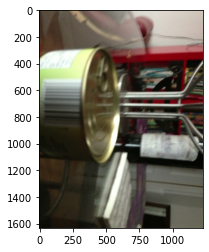

In [267]:
img = display_random_picture(df)

In [24]:
def plot_multiple_pictures(img_dataset, max_pictures_to_show):
    fig = plt.figure(figsize=(25,45))
    for i in range(len(img_dataset)):
        image, caption, length, url = img_dataset[i]
        if isinstance(image, torch.Tensor):
            image = invTrans(image)
        ax = plt.subplot(max_pictures_to_show, 2, i + 1)
        plt.tight_layout()
        if isinstance(image[0,0,0], np.float32) and image[0,0,0] > 5 and image[1,1,1] > 5:
            image = image.astype(int)
        plt.imshow(image)
        ax.set_title([vocab.itos[x] for x in caption if vocab.itos[x] != TOKEN_PAD])
        ax.axis('off')

        if i == max_pictures_to_show-1:
            plt.show()
            break


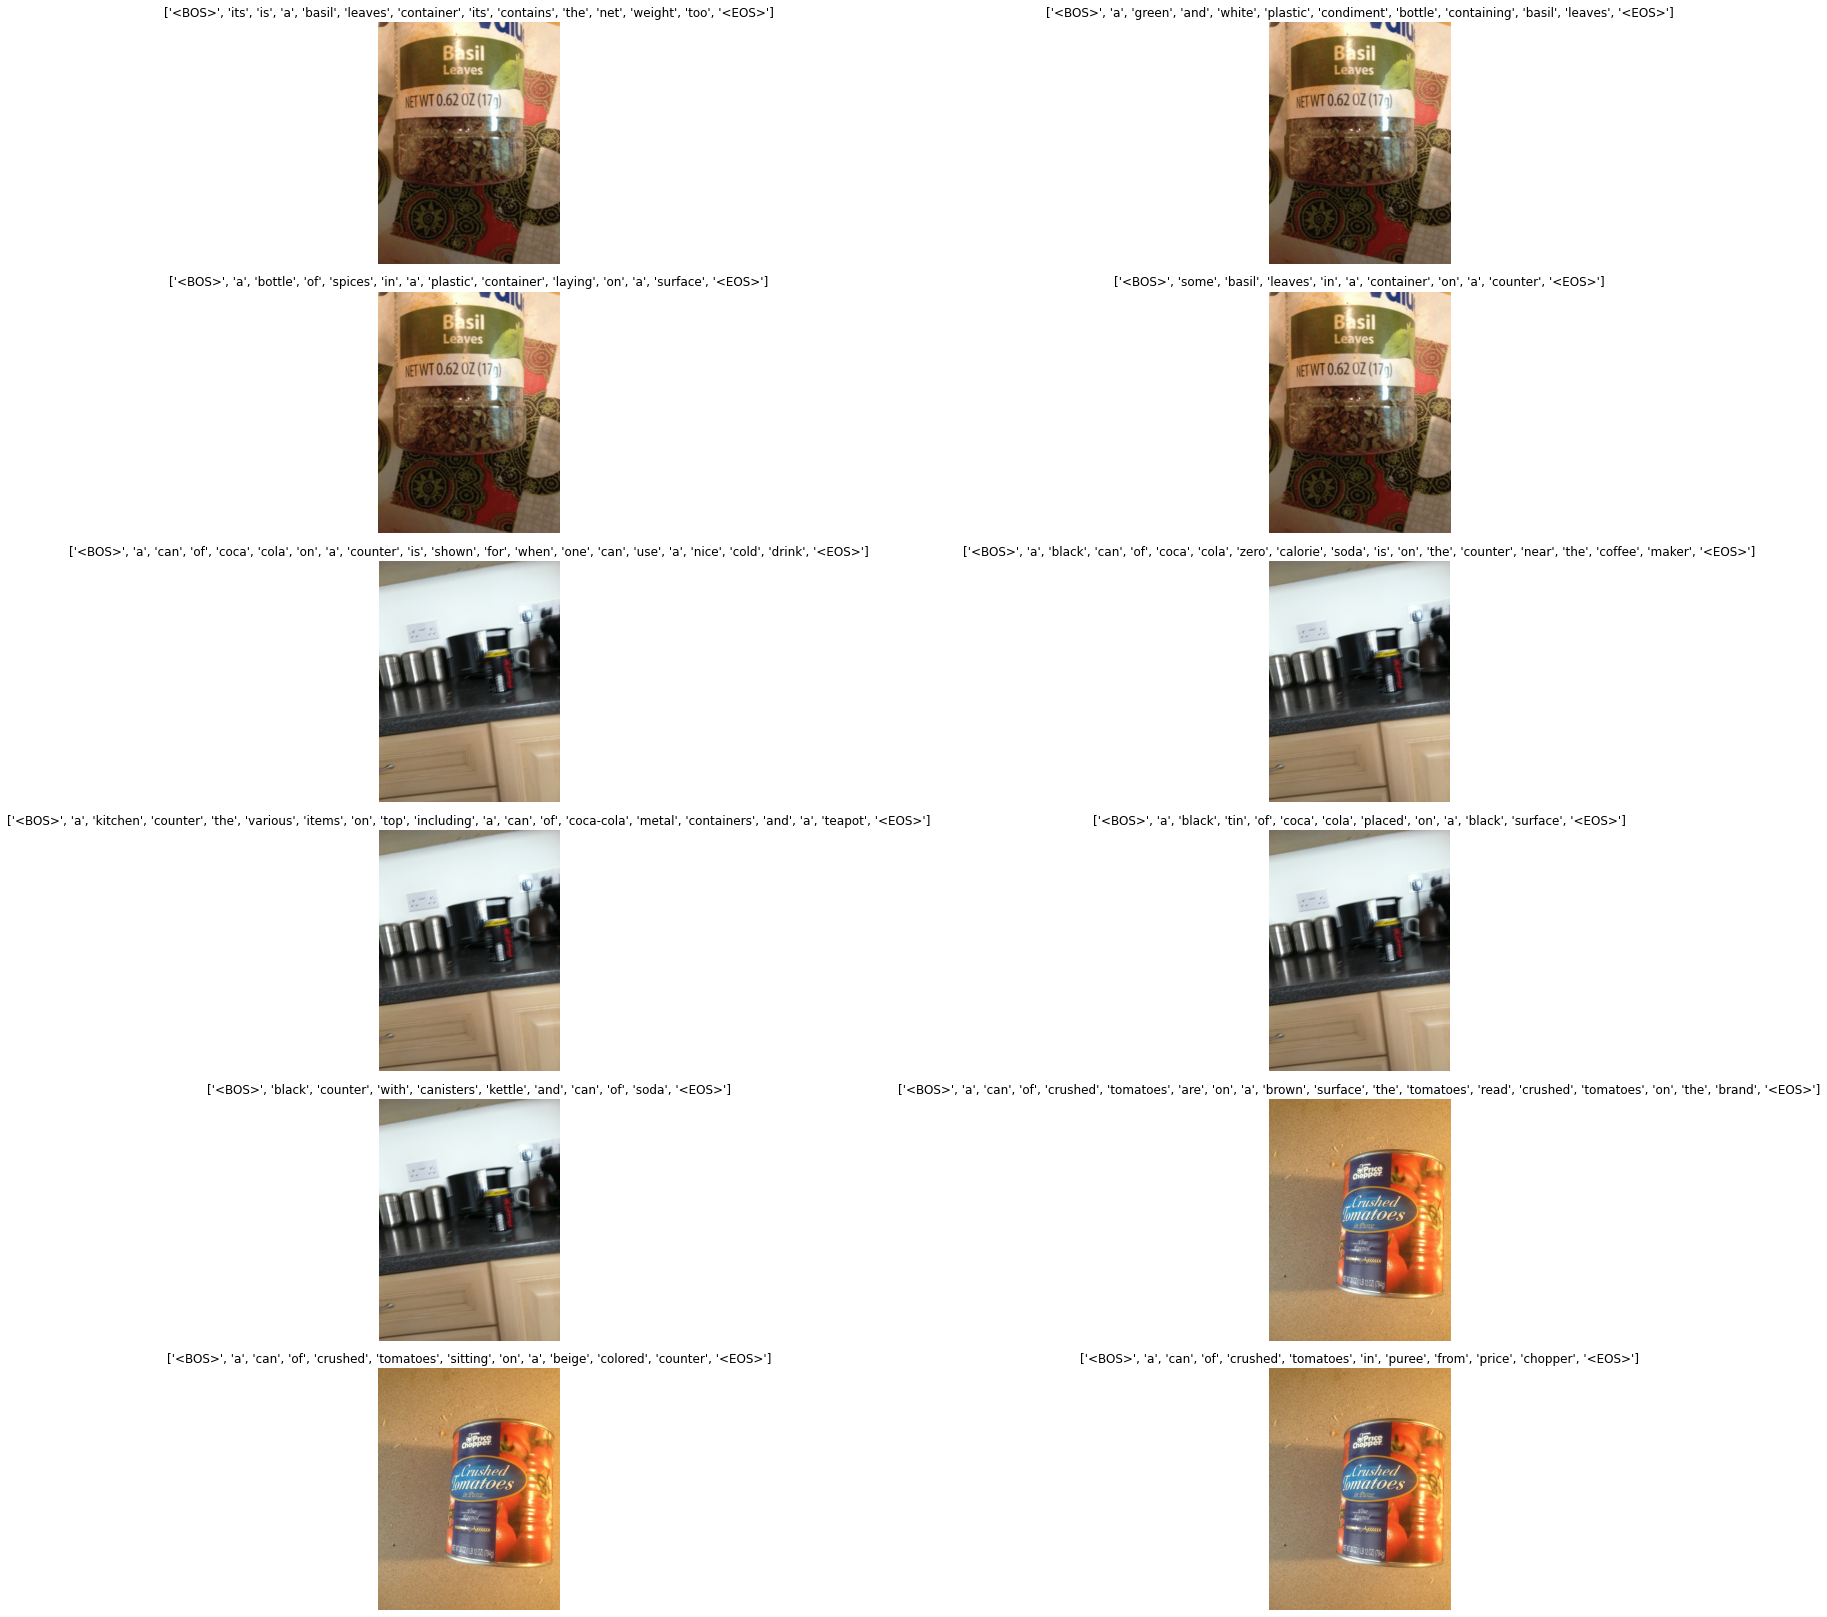

In [25]:
# Settings for Plotting
img_dataset = VizWizImageCaptioning(df=df)

max_pictures_to_show = 12

###
plot_multiple_pictures(img_dataset, max_pictures_to_show)

### Preprocessing Images
As defined in the page of [ResNet of Pytorch](https://pytorch.org/hub/pytorch_vision_resnet/), we need to preprocess the images in the following way and Pytorch offers [great Tools](https://pytorch.org/vision/stable/transforms.html) for this task.
- Pictures get resized to 256*256 (If the picture is not squared, the image gets scaled down, so that the longer side has 256 pixes. Now, the smaller side is padded up to 256 to make it a square with bilinear interpolation).
- A center-picture is extracted with a dimension of 244*244. 
- The RGB-Picture, with numeric values between 0 and 255 for colors, is min-max scaled between 0 and 1 (Pytorchs' `transforms.ToTensor()` does this automatically).
- The picture is standardised per color with the `Standard Deviation` and `Mean` calculated from millions of pictures of the images of [ImageNet](https://www.image-net.org/). 

Those are created with classes from `torchvision.transforms` and transformed into a processing-pipeline with [torchvision.transforms.Compose](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Compose).

In [50]:
###
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # ImageNet mean and std
    ]
)

# Inverse transformation to see if the transformation was good:
invTrans = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), 
    torchvision.transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),
    torchvision.transforms.ToPILImage(),
    ])

## Training of the Models
In this Section, the
- Parameters for the Models and Training are set
- DataLoaders are created
- Models are trained

### Model Parameters

In [39]:
## Parameter for the models:
model_param = {}
model_param['embedding_dim'] = 128
model_param['sentence_max_length'] = SENTENCE_MAX_LENGTH # 19. 
model_param['vocab_size'] = len(vocab)
model_param['dropout'] = 0.05
model_param['rnn_units'] = 300
model_param['num_layers'] = 1 # We reuse the cell over and over.
model_param['TOKEN_START'] = torch.tensor([vocab.stoi[TOKEN_START]]).to(device)


### Creation of the DataSets
The DataSet-Class `VizWizImageCaptioning` can be found in `dataloader.py`; It takes in a DataFrame containing preprocessed captions (tokenized, cleaned, padded, shorted, labeled-encoded) and where those pictures are located. Also, if to `transform` an object of type `torchvision.transforms.Compose`-object is passed, pictures will be preprocessed with that pipeline before used in training. Also, if `preload_images_to_memory` is set to `True`, images are preprocessed and stored into memory for faster training.

In [35]:
df_train = df.copy()

# Create Train-Test Split without overlap. A picture can have multiple captions, so it's possible that a picture would appear in train and test set. 
# It was manually checked that his does not happen. However, im not 100% sure if that is even bad.
dataset = {}
dataset['train'] = VizWizImageCaptioning(df=df_train.iloc[:69265], transform=transforms, preload_images_to_memory=True)
dataset['val'] = VizWizImageCaptioning(df=df_train.iloc[69265:], transform=transforms, preload_images_to_memory=True)



100%|██████████| 15735/15735 [04:36<00:00, 56.97it/s]
c:\Users\vince\Documents\FHNW\FS2021\DEL-2\dataloader.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['image_idx'] = df.groupby('url').ngroup()
100%|██████████| 3947/3947 [01:10<00:00, 55.82it/s]


device(type='cuda', index=0)

### Support-functions
Support-Functions for the training and/or evaluation of the models.

In [268]:
def load_random_image(df, transform=None, verbose=0):
    """Function to show the label and the picture of a random annotation."""
    rand_idx = np.random.randint(df.shape[0])
    random_row = df.iloc[rand_idx, :]
    image = mpimg.imread(random_row['url'])

    if transform is not None:
        image = transform(image)
        
    return image[None, ...], random_row['caption']
  
def predict_output(sampled_ids):
    sampled_ids = sampled_ids[0].cpu().numpy()   

    # Convert word_ids to words
    sampled_caption = []
    for i, word_id in enumerate(sampled_ids):
        word = vocab.itos[word_id]
        sampled_caption.append(word)
        if word == TOKEN_END:
            break
    sentence = ' '.join(sampled_caption)
    return sentence

### Parameter for the Training

In [269]:
# Parameter
training_param = {}
training_param['lr'] = 0.0001
training_param['epochs'] = 120
training_param['batch_size'] = 64
training_param['show_prediction_step'] = 100 # After how many steps a picture from the val-set of images and captions is captioned by our models. 
training_param['model_path'] = 'models/'
training_param['wandb_on'] = True # If the current run should be uploaded to WandB.
training_param['debug_on'] = False # Adds some debugging-functionality

In [ ]:
# Create DataLoader:
data_loader = {}
data_loader['train'], data_loader['val'] = DataLoader(dataset['train'], batch_size=training_param['batch_size'],drop_last=True), DataLoader(dataset['val'], batch_size=training_param['batch_size'], drop_last=True)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [159]:
#Create Val-Set
val_set = df_from_val_json(PATH_TO_ANN + 'val.json')
val_set.sample(5)

,url,caption
11911,data/val/VizWiz_val_00002382.jpg,Food packages like this one make me hungry.
22824,data/val/VizWiz_val_00004564.jpg,Silver remote where the stop button is red and...
16496,data/val/VizWiz_val_00003299.jpg,A person's leg in grey sweatpants and dark bac...
29236,data/val/VizWiz_val_00005847.jpg,a white and black cat asleep on a red cushione...
3893,data/val/VizWiz_val_00000778.jpg,a TV with a bunch of stuff on top of it


In [ ]:
# Build the models
if True: # Incase we would like to continue training, we could set this to false and not overwrite our models.
    encoder = EncoderCNN(model_param=model_param, cnn_model=models.resnet50(pretrained=True)).to(device)
    decoder = DecoderRNN(model_param=model_param).to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
    optimizer = torch.optim.Adam(params, lr=training_param['lr'])

    # Init wandb:
    if training_param['wandb_on']:
        run = wandb.init(reinit=True, project='DEL-2', mode="online")
    
# Print a nice bar with tqdm
t = tqdm(range(training_param['epochs'] + 1))

# Calculate total steps per Epoch
total_step = len(data_loader['train']) - 1

# Train the models.
for epoch in t:
    train_loss = 0
    for i, (images, captions, lengths, url) in enumerate(data_loader['train']):
        # Set mini-batch dataset
        images = images.to(device)
        captions = captions.to(device, dtype=torch.long)
        targets = pack_padded_sequence(captions, lengths.tolist(), enforce_sorted=False, batch_first=True)[0]

        # Forward, backward and optimize
        encoder.train()
        decoder.train()
        features = encoder(images)
        outputs = decoder(features, captions)
        
        outputs = pack_padded_sequence(outputs, lengths.tolist(), enforce_sorted=False, batch_first=True)[0]
        loss = criterion(outputs, targets)

        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()

        train_loss += loss.item() / len(data_loader['train'])

        optimizer.step()
        encoder.eval()
        decoder.eval()

        # Print log info
        t.set_description('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'.format(epoch, training_param['epochs'], i, total_step, loss.item(), np.exp(loss.item()))) 
            

        if training_param['wandb_on'] and epoch % 10 == 0 and i % training_param['show_prediction_step'] == 0:
            ## Upload and predict random picture to wandb:
            # Load random picture and predict it:
            img, caption = load_random_image(val_set, rand_idx=i, transform=transforms, verbose=0)
            image_tensor = (img).to(device)
            
            feature = encoder(image_tensor)
            sampled_ids = decoder.sample(feature)

            # Wandb:
            images = wandb.Image(img, caption="Prediction: {}\nTrue: {}".format(predict_output(sampled_ids), caption))
          
            run.log(
                {  
                "Example Epoch {}".format(epoch): images
                })
            
    # Display Train loss after epoch:
    if training_param['wandb_on']:
        run.log(
        {
            "Train-Loss": train_loss,
            "Train-Perplexity": np.exp(train_loss)
        })
        if training_param['debug_on']:
            run.log(
                {
                "Debug: Picture: ":  wandb.Image(images[0].cpu(), caption=' '.join([vocab.itos[x] for x in captions[0].cpu()]))
                })

    # Calc test loss:
    with torch.no_grad():
        test_loss = 0
        for i, (images, captions, lengths, url) in enumerate(data_loader['val']):
            # Cuda stuff:
            images = images.to(device)
            captions = captions.to(device, dtype=torch.long)
            targets = pack_padded_sequence(captions, lengths.tolist(), enforce_sorted=False, batch_first=True)[0]

            # Calculate loss:
            features = encoder(images)
            outputs = decoder.test_sample(features)
            outputs = pack_padded_sequence(outputs, lengths.tolist(), enforce_sorted=False, batch_first=True)[0]

            test_loss += criterion(outputs, targets).item() / len(data_loader['val'])

        if training_param['wandb_on']:
            run.log(
            {   "Epoch" : epoch,
                "Val-Loss": test_loss ,
                "Val-Perplexity": np.exp(test_loss)
            })
        
    # Save models after each epoch:
    torch.save(decoder.state_dict(), os.path.join(
        training_param['model_path'], 'decoder-epoch-{}.ckpt'.format(epoch+1)))
    torch.save(encoder.state_dict(), os.path.join(
        training_param['model_path'], 'encoder-epoch-{}.ckpt'.format(epoch+1)))

            
run.finish()

## Evaluation
### Pictures of the validation-set
The Dashboard by WandB can be found [->here<-](https://wandb.ai/vincenzo293/DEL-2/runs/fhfd7ry9?workspace=user-vincenzo293). 

It shows the caption of one random picture per Epoch (a Feature, not a Bug) and a couple of pictures captioned by the model at different training-epochs. We can see that the Quality definately improves over the Epoch and we could have probably let it train even longer. Personally, I have to say that some pictures are even very hard for me to caption. Also, it contains a short analysis about the Loss and some thoughts about it at the bottom.

Often it seems to get the colours wrong, which seems wierd because that seems to be the much easier task than to "see" what is on the pictures. It could be that the CNN-Model is pretrained to classify, so the colour-information is unused for the pretrained model.
Very interesting is, that the Model actually somehow "invents" stuff, for example saying what there is on the book-cover, even though we only see a page of the book. I guess that is because the Model is not complex enough to make up everything there is on the picture, so it describes what there is but then needs to fill up the remaining words with something because the `true caption` is longer. This would reduce loss.

### Evaluating own Pictures
For this, we need to load our saved models define from where we want to read the pictures.

#### Loading Models

In [271]:
# Set some Parameters:
import  os, random

PATH_TO_IMAGES = 'data/own_pictures/'
PATH_TO_ENCODER = 'models/encoder-epoch-80.ckpt'
PATH_TO_DECODER = 'models/decoder-epoch-80.ckpt'
# Load Models with settings:
# Define device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
encoder = EncoderCNN(model_param=model_param, cnn_model=models.resnet50(pretrained=True)).to(device)
decoder = DecoderRNN(model_param=model_param).to(device)

# Load weights:
encoder.load_state_dict(torch.load(PATH_TO_ENCODER))
decoder.load_state_dict(torch.load(PATH_TO_DECODER))

# Set both models to eval mode:
encoder.eval()
decoder.eval()

DecoderRNN(
  (word_embeddings): Embedding(8778, 128)
  (inv_word_embeddings): Linear(in_features=128, out_features=8778, bias=True)
  (lstm): LSTM(128, 128, batch_first=True)
)

#### Create Functions to load images

In [232]:
def load_random_img(path='./', transform=transforms, specific_path=None):
    """Shows and labels a random image located in a folder"""
    if not specific_path:
        rnd_img = random.choice(os.listdir(path))
        print("Showing {}".format(rnd_img))
        url = path+rnd_img
    else:
        url = specific_path
        
    img = mpimg.imread(url)
    # Show image:
    plt.imshow(img)
    
    if transform is not None:
        img = transform(img)

    # Generate caption:
    encoder.eval()
    decoder.eval()
    
    image_tensor = (img[None, ...]).to(device)
    
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    print("Caption:" , predict_output(sampled_ids))

    return True

Showing IMG_7135.jpeg
Caption: <BOS> a person is holding a small white candle in a room <EOS>


True

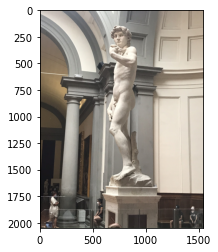

In [327]:
load_random_img(path=PATH_TO_IMAGES)

Showing IMG_8439.jpeg
Caption: <BOS> a dog with a fence in the background and a red fence <EOS>


True

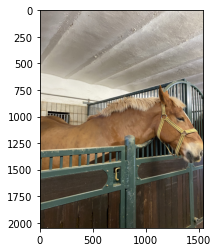

In [70]:
load_random_img()

Showing IMG_8558.JPEG
Caption: <BOS> a white and black pair of scissors on a wooden table <EOS>


True

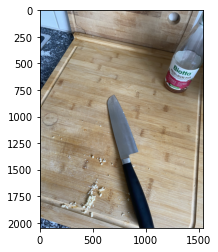

In [71]:
load_random_img()

Showing IMG_8378.JPEG
Caption: <BOS> a picture of a house with a blue sky and a cloudy sky <EOS>


True

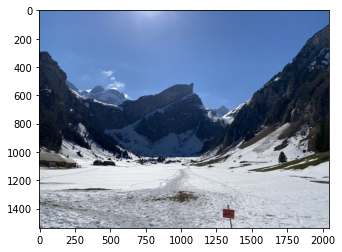

In [85]:
load_random_img()

Showing IMG_8556.JPEG
Caption: <BOS> a black and white electronic device with a cord plugged into it <EOS>


True

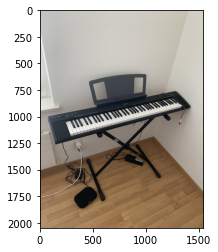

In [86]:
load_random_img()

Showing IMG_8555.JPEG
Caption: <BOS> a black desk with a computer keyboard and a black and white keyboard <EOS>


True

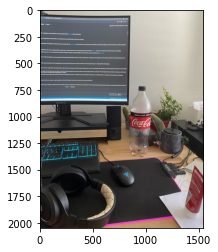

In [112]:
load_random_img()

Showing IMG_8557.JPEG
Caption: <BOS> a white and black colored flower arrangement of flowers <EOS>


True

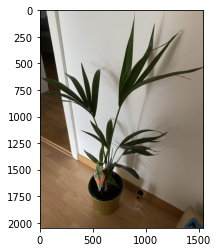

In [120]:
load_random_img()

#### Comments
It seems that own pictures are captioned ok-ish; But some are completely wrong. However, the rest are somewhat OK or the errors are understandable. The last three pictures are close to perfect and their errors are understandable.

### Evaluating Images from the Valdation-Set
Those Pictures were already used on WandB during Training. However, I guess it's nice to analyse some of them here.

In [154]:
# PARAMS
PATH_TO_IMAGES = 'data/val/'

Showing VizWiz_val_00003403.jpg
Caption: <BOS> a decorative plant with a flower design on a wooden table <EOS>


True

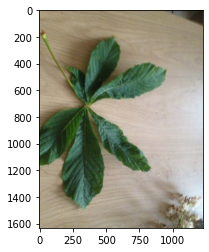

In [155]:
load_random_img(path=PATH_TO_IMAGES)

Showing VizWiz_val_00003918.jpg
Caption: <BOS> a book is on a table with a person ' s legs <EOS>


True

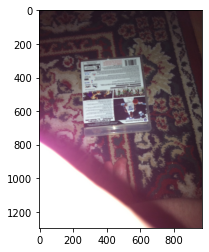

In [158]:
load_random_img(path=PATH_TO_IMAGES)

Showing VizWiz_val_00005721.jpg
Caption: <BOS> a red coca cola can be seen in a red box <EOS>


True

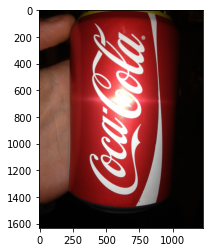

In [172]:
load_random_img(path=PATH_TO_IMAGES)

Showing VizWiz_val_00001053.jpg
Caption: <BOS> a white and yellow box sitting on a brown table <EOS>


True

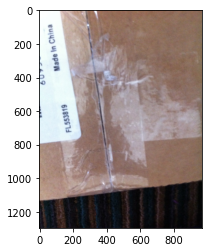

In [173]:
load_random_img(path=PATH_TO_IMAGES)

Showing VizWiz_val_00000832.jpg
Caption: <BOS> a white piece of paper with a white label on it <EOS>


True

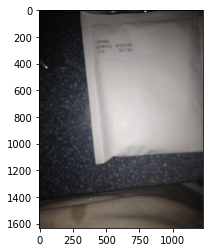

In [174]:
load_random_img(path=PATH_TO_IMAGES)

Showing VizWiz_val_00002548.jpg
Caption: <BOS> a white paper with a paper on it <EOS>


True

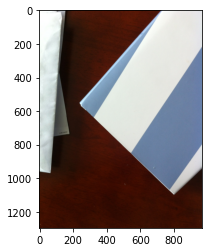

In [175]:
load_random_img(path=PATH_TO_IMAGES)

Showing VizWiz_val_00002530.jpg
Caption: <BOS> the back of a red package of food with a yellow label <EOS>


True

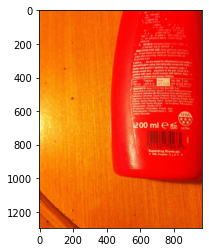

In [176]:
load_random_img(path=PATH_TO_IMAGES)

Showing VizWiz_val_00004453.jpg
Caption: <BOS> a black and white chair chair with a chair in the background <EOS>


True

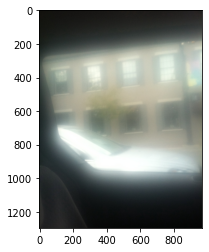

In [177]:
load_random_img(path=PATH_TO_IMAGES)

Showing VizWiz_val_00002073.jpg
Caption: <BOS> a red and white bag of chips <EOS>


True

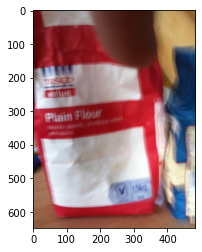

In [180]:
load_random_img(path=PATH_TO_IMAGES)

Showing VizWiz_val_00001872.jpg
Caption: <BOS> a box of pasta roni chicken and cheese <EOS>


True

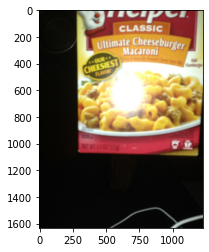

In [182]:
load_random_img(path=PATH_TO_IMAGES)

Showing VizWiz_val_00001571.jpg
Caption: <BOS> a close up of a grey fabric or blanket or blanket <EOS>


True

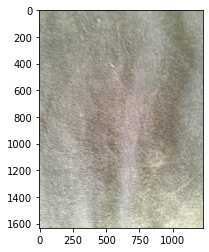

In [186]:
load_random_img(path=PATH_TO_IMAGES)

Showing VizWiz_val_00001963.jpg
Caption: <BOS> a black remote control for a television set <EOS>


True

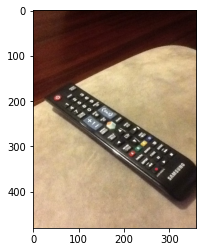

In [184]:
load_random_img(path=PATH_TO_IMAGES)

Showing VizWiz_val_00002634.jpg
Caption: <BOS> a black and silver colored remote control with a black and white label <EOS>


True

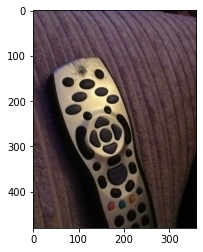

In [185]:
load_random_img(path=PATH_TO_IMAGES)

Showing VizWiz_val_00006032.jpg
Caption: <BOS> page on a book about a book about a culture of <unk> <EOS>


True

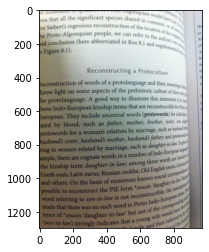

In [187]:
load_random_img(path=PATH_TO_IMAGES)

Showing VizWiz_val_00007034.jpg
Caption: <BOS> a white paper with text on it <EOS>


True

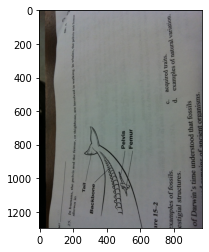

In [188]:
load_random_img(path=PATH_TO_IMAGES)

Showing VizWiz_val_00001206.jpg
Caption: <BOS> a box of frozen pizza with a picture of a food on the front <EOS>


True

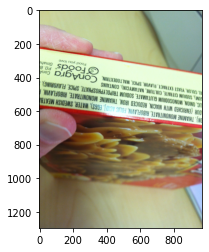

In [189]:
load_random_img(path=PATH_TO_IMAGES)

Showing VizWiz_val_00007096.jpg
Caption: <BOS> a bottle of <unk> brand <unk> <unk> <unk> <unk> <EOS>


True

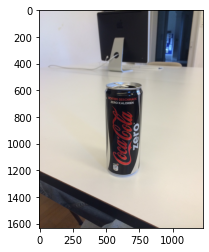

In [190]:
load_random_img(path=PATH_TO_IMAGES)

Showing VizWiz_val_00003582.jpg
Caption: <BOS> a picture of a bottle of <unk> ' s mustard <EOS>


True

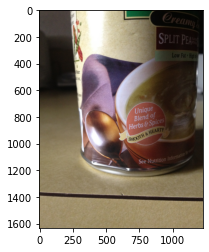

In [191]:
load_random_img(path=PATH_TO_IMAGES)

Showing VizWiz_val_00004546.jpg
Caption: <BOS> a red box of coffee maker is on a table <EOS>


True

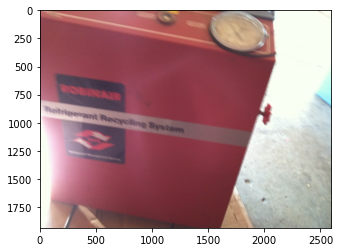

In [192]:
load_random_img(path=PATH_TO_IMAGES)

Showing VizWiz_val_00001536.jpg
Caption: <BOS> a can of green beans on a counter <EOS>


True

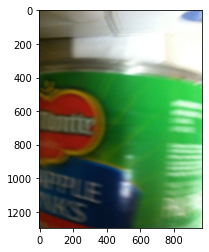

In [193]:
load_random_img(path=PATH_TO_IMAGES)

Showing VizWiz_val_00005438.jpg
Caption: <BOS> orange orange and orange and white stripes <EOS>


True

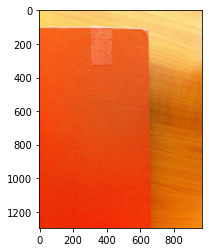

In [194]:
load_random_img(path=PATH_TO_IMAGES)

Showing VizWiz_val_00001553.jpg
Caption: <BOS> orange bag of potato chips on a blue fabric surface <EOS>


True

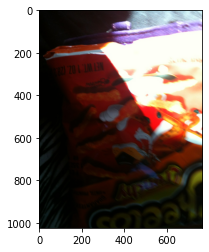

In [197]:
load_random_img(path=PATH_TO_IMAGES)

Showing VizWiz_val_00000255.jpg
Caption: <BOS> a person holding a bottle of water with a yellow and orange label <EOS>


True

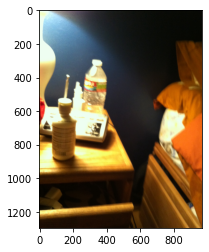

In [196]:
load_random_img(path=PATH_TO_IMAGES)

Showing VizWiz_val_00004587.jpg
Caption: <BOS> a thermostat with a white button on it is shown <EOS>


True

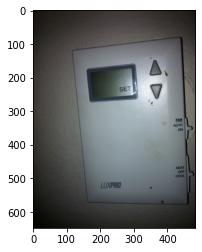

In [204]:
load_random_img(path=PATH_TO_IMAGES)

Showing VizWiz_val_00004897.jpg
Caption: <BOS> a cd case with a picture of a man in the background <EOS>


True

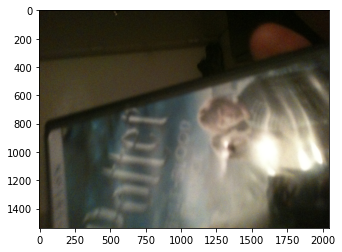

In [224]:
load_random_img(path=PATH_TO_IMAGES)

#### Comments
Some are incredible impressive, especially when it can understand what it is and what is written on it (Example: `a box of pasta roni chicken and cheese` ). Others are completely wrong. However, a very simple architecture was used and no powerful NLP-tools (pretrained embeddings, pretrained models, ..) were applied.

Overall, im incredible impressed with the quality and excited to enhance this simple model further.